In [ ]:
# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
emp_data = pd.read_csv('/content/employeesdata.csv')

In [ ]:
emp_data.head(3)

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49


In [ ]:
emp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


# **1. Data Cleaning**

Data Cleaning is an essential step in data preprocessing that involves identifying and correcting data errors in datasets to improve the quality of the data for analysis or machine learning tasks.

## **1.1 Handling Missing Values**

In [ ]:
#check for missing values
missing = emp_data.isnull().sum()
print(missing)

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64


In this step, I use a threshold of **5%** for handling missing values.  
*  If a column has less than 5% of its values missing, the corresponding rows are dropped.
*  If a column has more than 5% of its values missing, imputation is applied to fill in the missing data.

In [ ]:
# print the threshold
threshold = len(emp_data) * 0.05
print(threshold)

1137.5


In [ ]:
# check for column with missing values <= threshold
cols_to_dropna = emp_data.columns[(missing > 0) & (missing <= threshold)]
print(cols_to_dropna)

Index(['Burn Rate'], dtype='object')


In [ ]:
#drop the rows
emp_data.dropna(subset=cols_to_dropna, inplace=True)
print(emp_data.isna().sum())

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1278
Mental Fatigue Score    1945
Burn Rate                  0
dtype: int64


In [ ]:
# check for column with missing values > threshold
cols_with_missval = emp_data.columns[emp_data.isna().sum() > 0]
print(cols_with_missval)

Index(['Resource Allocation', 'Mental Fatigue Score'], dtype='object')


In [ ]:
# fill missing values with the column's mean
for col in cols_with_missval:
    emp_data[col].fillna(emp_data[col].mean(), inplace=True)

print(emp_data.isna().sum())

Employee ID             0
Date of Joining         0
Gender                  0
Company Type            0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
Burn Rate               0
dtype: int64


## **1.2 Outlier Detection and Removal**

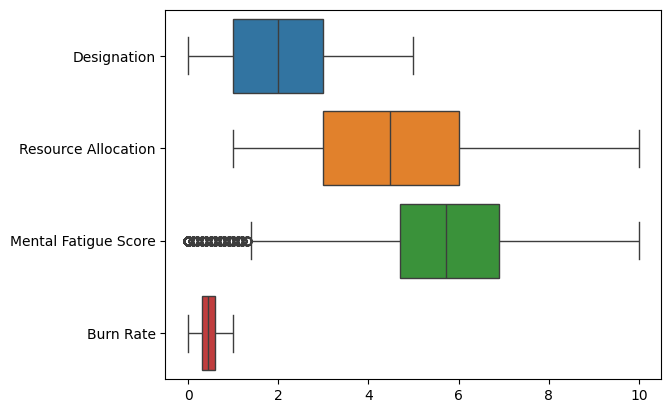

In [ ]:
# visualize outliers using boxplots
sns.boxplot(data=emp_data, orient='h')
plt.show()

In [ ]:
# 75th percentile
seventy_fifth = emp_data['Mental Fatigue Score'].quantile(0.75)
# 25th percentile
twenty_fifth = emp_data['Mental Fatigue Score'].quantile(0.25)

# interquartile range
mfs_iqr = seventy_fifth - twenty_fifth
print(mfs_iqr)

2.2


In [ ]:
# upper threshold
upper = seventy_fifth + (1.5 * mfs_iqr)
# lower threshold
lower = twenty_fifth - (1.5 * mfs_iqr)
print(upper, lower)

10.200000000000001 1.4


In [ ]:
# print the number of outliers
outliers = emp_data[(emp_data['Mental Fatigue Score'] > upper) | (emp_data['Mental Fatigue Score'] < lower)]
print(len(outliers))

482


In [ ]:
# remove outliers
emp_data = emp_data[(emp_data['Mental Fatigue Score'] < upper) & (emp_data['Mental Fatigue Score'] > lower)]

In [ ]:
# recheck
outliers = emp_data[(emp_data['Mental Fatigue Score'] > upper) | (emp_data['Mental Fatigue Score'] < lower)]
print(len(outliers))

0


## **1.3 Checking Duplicates**

In [ ]:
# print the number of duplicates
emp_data.duplicated().sum()

0

# **2. Feature Adjustment**

Some features in the dataset, though informative, may not be directly useful for analysis. It might be beneficial to adjust certain features to ensure the relevance and accuracy of the results.

In [ ]:
#print datatypes
print(emp_data.dtypes)

Employee ID              object
Date of Joining          object
Gender                   object
Company Type             object
WFH Setup Available      object
Designation             float64
Resource Allocation     float64
Mental Fatigue Score    float64
Burn Rate               float64
dtype: object


## **2.1  Deriving Features**

The 'Date of Joining' features provides a temporal context but is not directly actionable for analysis in its raw form. To make the data more useful, we derive a new feature called 'Working Duration,' which calculates the total time an employee has been with the company.

In [ ]:
#convert to datetime type
emp_data['Date of Joining'] = pd.to_datetime(emp_data['Date of Joining'])

In [ ]:
from datetime import datetime
current_date = pd.to_datetime(datetime.now().date())

# calculate the 'Working Duration' as the difference between the current date and 'Date of Joining'
working_dur = (current_date - emp_data['Date of Joining']).dt.days

# convert working duration from days to years
working_dury = working_dur / 365
emp_data.insert(loc=2, column='Working Duration', value=working_dury)

In [ ]:
emp_data.head(3)

,Employee ID,Date of Joining,Working Duration,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,15.969863,Female,Service,No,2.0,3.000000,3.8,0.16
1,fffe3700360033003500,2008-11-30,15.802740,Male,Service,Yes,1.0,2.000000,5.0,0.36
2,fffe31003300320037003900,2008-03-10,16.528767,Female,Product,Yes,2.0,4.483831,5.8,0.49


## **2.2 Encoding Categorical Features**

In [ ]:
ecols = ['Gender', 'Company Type', 'WFH Setup Available']

In [ ]:
for col in ecols:
    print(f"Unique values in {col}:")
    print(emp_data[col].unique())
    print()

Unique values in Gender:
['Female' 'Male']

Unique values in Company Type:
['Service' 'Product']

Unique values in WFH Setup Available:
['No' 'Yes']



In [ ]:
# perform one-hot-encoding
is_Male = pd.get_dummies(emp_data["Gender"], drop_first=True)
is_Service  = pd.get_dummies(emp_data["Company Type"], drop_first=True)
WFH_Available = pd.get_dummies(emp_data["WFH Setup Available"], drop_first=True)

In [ ]:
# insert to emp_data
for loc, column in enumerate(["is_Male", "is_Service", "WFH_Available"], start=3):
    emp_data.insert(loc=loc, column=column, value=eval(column))

In [ ]:
# drop columns that are no longer needed
emp_data.drop(columns=['Date of Joining','Gender', 'Company Type', 'WFH Setup Available'], axis=1, inplace=True)

In [ ]:
emp_data.head(3)

,Employee ID,Working Duration,is_Male,is_Service,WFH_Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,15.969863,False,True,False,2.0,3.000000,3.8,0.16
1,fffe3700360033003500,15.802740,True,True,True,1.0,2.000000,5.0,0.36
2,fffe31003300320037003900,16.528767,False,False,True,2.0,4.483831,5.8,0.49


# **3. Data Integration**

Data integration is the process of combining data from multiple sources into one coherent form. When data is integrated from different sources,  data redundancy often occurs. Redundant attributes may be able to be detected by **correlation analysis** and **covariance analysis**.

## **3.1 Correlation Analysis**

In [ ]:
#drop employee id
emp_data =emp_data.drop(columns=['Employee ID'])

In [ ]:
# calculate the correlation matrix
emp_data.corr()

,Working Duration,is_Male,is_Service,WFH_Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
Working Duration,1.000000,-0.000937,-0.003297,0.001774,-0.002307,-0.001124,-0.005382,-0.001835
is_Male,-0.000937,1.000000,-0.011517,-0.074944,0.111601,0.137839,0.146709,0.158508
is_Service,-0.003297,-0.011517,1.000000,0.004805,0.005387,0.006185,0.000496,0.002925
WFH_Available,0.001774,-0.074944,0.004805,1.000000,-0.231306,-0.280489,-0.277952,-0.314744
Designation,-0.002307,0.111601,0.005387,-0.231306,1.000000,0.846539,0.637116,0.721454
Resource Allocation,-0.001124,0.137839,0.006185,-0.280489,0.846539,1.000000,0.729262,0.821255
Mental Fatigue Score,-0.005382,0.146709,0.000496,-0.277952,0.637116,0.729262,1.000000,0.888771
Burn Rate,-0.001835,0.158508,0.002925,-0.314744,0.721454,0.821255,0.888771,1.000000


<Axes: >

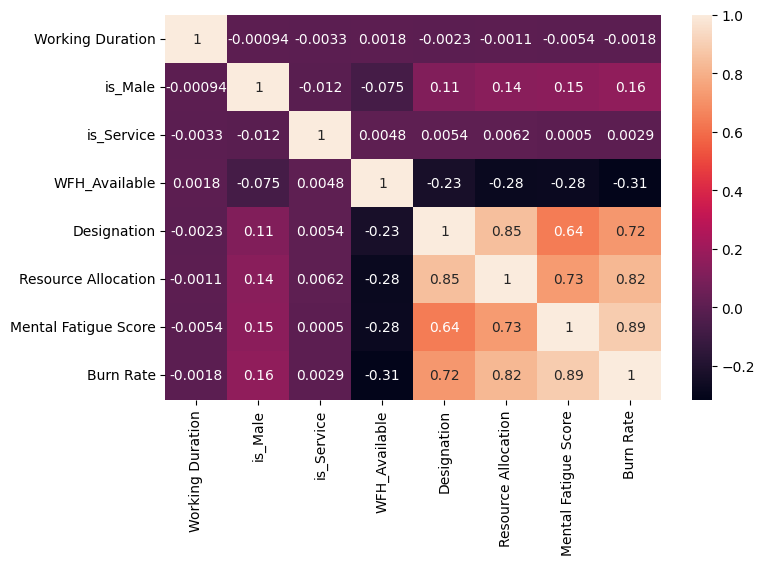

In [ ]:
# create heatmap to visualize correlation matrix
plt.figure(figsize=(8,5))
sns.heatmap(data=emp_data.corr(),
            annot=True)

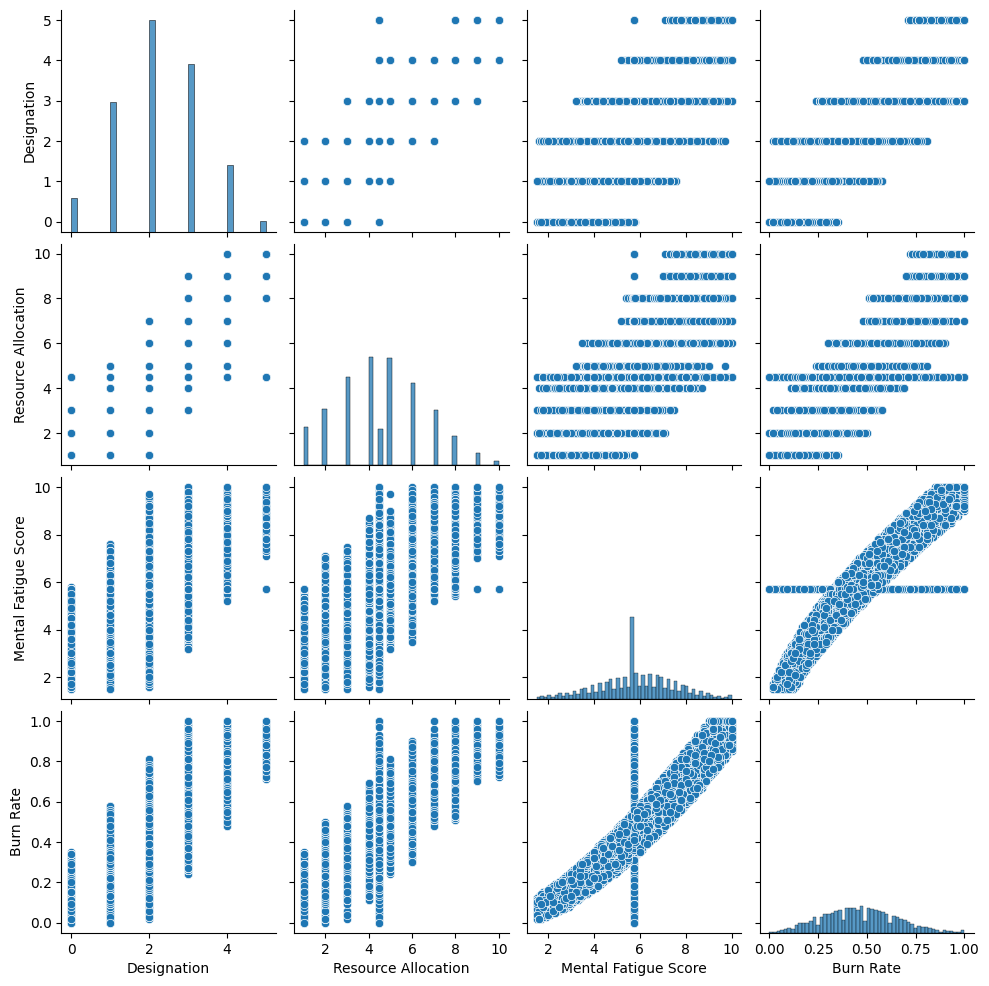

In [ ]:
# generate pairplot to visualize the relationships
sns.pairplot(data=emp_data, vars=['Designation', 'Resource Allocation', 'Mental Fatigue Score', 'Burn Rate'])
plt.show()

## **3.2 Covariance Analysis**

In [ ]:
# calculate the covariance matrix
covariance_matrix = emp_data.cov()

# print the covariance matrix
print(covariance_matrix)

                      Working Duration   is_Male  is_Service  WFH_Available  \
Working Duration              0.083335 -0.000135   -0.000453       0.000255   
is_Male                      -0.000135  0.249476   -0.002738      -0.018665   
is_Service                   -0.000453 -0.002738    0.226468       0.001140   
WFH_Available                 0.000255 -0.018665    0.001140       0.248624   
Designation                  -0.000742  0.062060    0.002854      -0.128406   
Resource Allocation          -0.000631  0.133857    0.005723      -0.271921   
Mental Fatigue Score         -0.002586  0.121984    0.000393      -0.230713   
Burn Rate                    -0.000100  0.014958    0.000263      -0.029651   

                      Designation  Resource Allocation  Mental Fatigue Score  \
Working Duration        -0.000742            -0.000631             -0.002586   
is_Male                  0.062060             0.133857              0.121984   
is_Service               0.002854             0.

# **4. Data Reduction**

Data Reduction refers to the techniques used to reduce the size of a dataset while still preserving its essential characteristics. This process helps to improve efficiency and reduce storage and computational costs. Data reduction can be achieved through various methods, one of which is **dimensionality reduction**.

## **4.1 Applying PCA**

In [ ]:
# importing necessary library
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
numeric_cols = ['Working Duration', 'Designation', 'Resource Allocation', 'Mental Fatigue Score', 'Burn Rate']

In [ ]:
# perform scaling for numeric columns
scaler = StandardScaler()
emp_data[numeric_cols] = scaler.fit_transform(emp_data[numeric_cols])

In [ ]:
# apply PCA
pca = PCA()
pc = pca.fit_transform(emp_data)
print(pc)

[[-1.90065291  0.86476697  0.87914758 ... -0.81873715  0.37576353
  -0.3454287 ]
 [-1.73711186  1.44756148 -0.63735512 ...  0.46557942  0.18701151
   0.23079779]
 [-0.12107353 -1.07593418 -0.10899744 ...  0.36662615 -0.20038455
   0.1605836 ]
 ...
 [ 1.62416884  1.19540826  0.45222343 ...  0.51374144 -0.76350581
   0.7439074 ]
 [ 0.21349768 -1.64403179 -0.18862265 ... -0.68699559 -0.26178595
   0.09756444]
 [ 1.75007123 -1.68509521 -0.35840972 ... -0.13370361  0.20408963
  -0.25123867]]


In [ ]:
# print explained variance ratio for each principal component
print(pca.explained_variance_ratio_)

[0.58623259 0.17468787 0.07737937 0.04271046 0.03948    0.03888149
 0.02459016 0.01603806]


In [ ]:
# print the cummulative explained variance ratio of the principal components
print(pca.explained_variance_ratio_.cumsum())

[0.58623259 0.76092046 0.83829983 0.88101029 0.92049029 0.95937178
 0.98396194 1.        ]


In [ ]:
# print the principal components of the PCA
print(pca.components_)

[[-2.26881545e-03  4.50075028e-02  1.06520203e-03 -8.86612824e-02
   4.77792393e-01  5.08734953e-01  4.87603632e-01  5.15027276e-01]
 [-9.99983989e-01  2.40087100e-04  2.00387804e-03 -3.62530270e-04
  -2.19398116e-03 -3.46994117e-03  2.83375320e-03 -1.71265155e-03]
 [-3.66543809e-03 -6.95621798e-02  1.05996965e-02  8.54773007e-02
   6.44063170e-01  3.27950041e-01 -5.90424094e-01 -3.41701241e-01]
 [-3.92595301e-04  9.43063484e-01 -1.59539956e-01 -2.59421749e-01
  -9.77265699e-03  3.33198366e-02 -1.25041929e-01 -3.22066663e-02]
 [-1.98046804e-03 -1.81440102e-01 -9.81564274e-01 -5.88733300e-02
   9.95852677e-03 -4.36457487e-03  4.54339478e-03 -1.48656285e-03]
 [-6.35380578e-05  2.63322386e-01 -1.04035121e-01  9.46312805e-01
   5.51496242e-02 -4.43154607e-02  1.39008999e-01  1.11442305e-03]
 [ 2.43097444e-03  3.58386566e-02  1.15556182e-02 -1.22356689e-01
   5.88403946e-01 -7.17421900e-01  3.12824367e-01 -1.57583370e-01]
 [-1.85713657e-03 -1.49343962e-02 -2.05817698e-03  5.98989035e-02
   

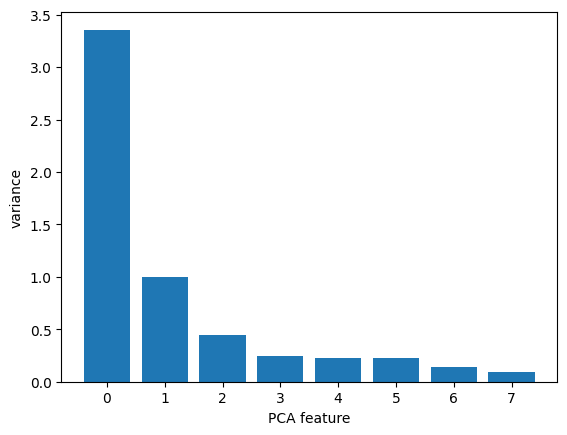

In [ ]:
# create a bar plot of the variance explained by each principal component
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()

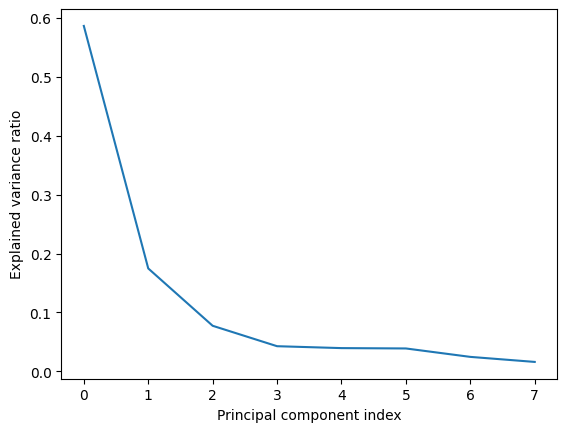

In [ ]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.show()

## **4.2 Checking the Effect of Categorical Features**

In [ ]:
emp_categories = emp_data[['is_Male', 'is_Service', 'WFH_Available']]

<ipython-input-47-7fa4c01f2f9e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emp_categories['PC 1'] = pc[:,0]
<ipython-input-47-7fa4c01f2f9e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emp_categories['PC 2'] = pc[:,1]


<Axes: xlabel='PC 1', ylabel='PC 2'>

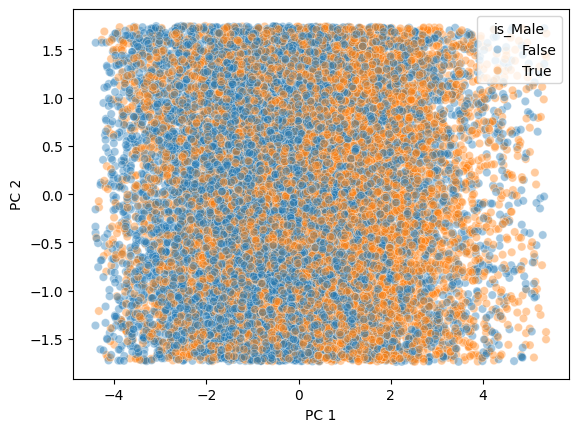

In [ ]:
emp_categories['PC 1'] = pc[:,0]
emp_categories['PC 2'] = pc[:,1]
sns.scatterplot(data=emp_categories,
                x='PC 1', y='PC 2',
                hue='is_Male', alpha=0.4)

<ipython-input-48-aa6c06256a6a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emp_categories['PC 1'] = pc[:,0]
<ipython-input-48-aa6c06256a6a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emp_categories['PC 2'] = pc[:,1]


<Axes: xlabel='PC 1', ylabel='PC 2'>

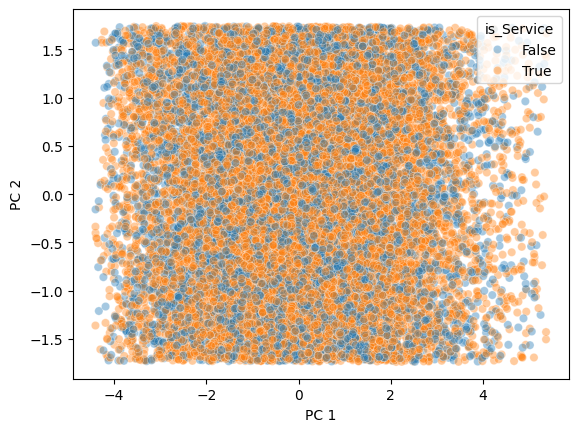

In [ ]:
emp_categories['PC 1'] = pc[:,0]
emp_categories['PC 2'] = pc[:,1]
sns.scatterplot(data=emp_categories,
                x='PC 1', y='PC 2',
                hue='is_Service', alpha=0.4)

<ipython-input-49-6fa475968fda>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emp_categories['PC 1'] = pc[:,0]
<ipython-input-49-6fa475968fda>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emp_categories['PC 2'] = pc[:,1]


<Axes: xlabel='PC 1', ylabel='PC 2'>

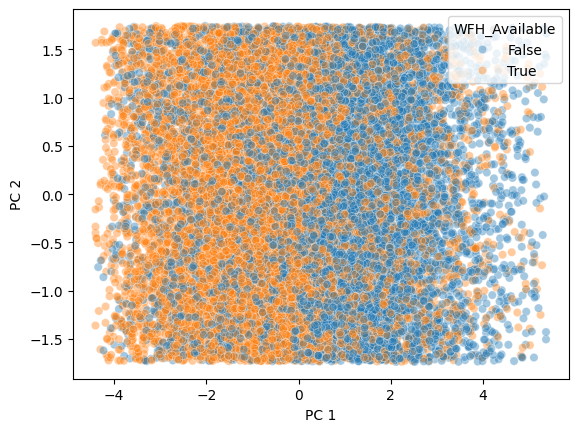

In [ ]:
emp_categories['PC 1'] = pc[:,0]
emp_categories['PC 2'] = pc[:,1]
sns.scatterplot(data=emp_categories,
                x='PC 1', y='PC 2',
                hue='WFH_Available', alpha=0.4)